# Description of the Competetion
Imagine one day, your breathing became consistently labored and shallow. Months later you were finally diagnosed with pulmonary fibrosis, a disorder with no known cause and no known cure, created by scarring of the lungs. If that happened to you, you would want to know your prognosis. That’s where a troubling disease becomes frightening for the patient: outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. Your help, and data science, may be able to aid in this prediction, which would dramatically help both patients and clinicians.

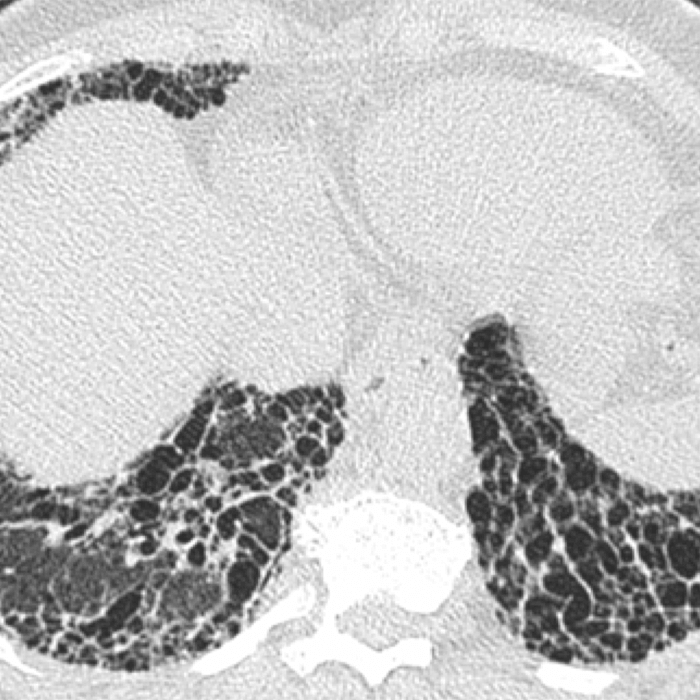

Current methods make fibrotic lung diseases difficult to treat, even with access to a chest CT scan. In addition, the wide range of varied prognoses create issues organizing clinical trials. Finally, patients suffer extreme anxiety—in addition to fibrosis-related symptoms—from the disease’s opaque path of progression.

[Open Source Imaging Consortium (OSIC)](https://www.osicild.org/) is a not-for-profit, co-operative effort between academia, industry and philanthropy. The group enables rapid advances in the fight against Idiopathic Pulmonary Fibrosis (IPF), fibrosing interstitial lung diseases (ILDs), and other respiratory diseases, including emphysematous conditions. Its mission is to bring together radiologists, clinicians and computational scientists from around the world to improve imaging-based treatments.

In this competition, you’ll predict a patient’s severity of decline in lung function based on a CT scan of their lungs. You’ll determine lung function based on output from a spirometer, which measures the volume of air inhaled and exhaled. The challenge is to use machine learning techniques to make a prediction with the image, metadata, and baseline FVC as input.

If successful, patients and their families would better understand their prognosis when they are first diagnosed with this incurable lung disease. Improved severity detection would also positively impact treatment trial design and accelerate the clinical development of novel treatments.

# ----------OSIC Pulmonary Fibrosis Progression Analysis------------

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
# Load Data
df_train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

In [ ]:
# Print Data Shape
print(f'Training Set Shape = {df_train.shape} - Patients = {df_train["Patient"].nunique()}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape = {df_test.shape} - Patients = {df_test["Patient"].nunique()}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set has 176 Patients

In [ ]:
# Training Set FVC Measurements Per Patient
training_sample_counts = df_train.rename(columns={'Weeks': 'Samples'}).groupby('Patient').agg('count')['Samples'].value_counts()
print(f'Training Set FVC Measurements Per Patient \n{("-") * 41}\n{training_sample_counts}')

In [ ]:
df_test.head(2)

#### Load Submission Data

In [ ]:
df_submission = pd.read_csv( '../input/osic-pulmonary-fibrosis-progression/sample_submission.csv' )
df_submission.head()

## Laplace Log Likelihood


`Confidence` values smaller than 70 are clipped.

$\large \sigma_{clipped} = max(\sigma, 70),$

Errors greater than 1000 are also clipped in order to avoid large errors.

$\large \Delta = min ( |FVC_{true} - FVC_{predicted}|, 1000 ),$

The metric is defined as:

$\Large metric = -   \frac{\sqrt{2} \Delta}{\sigma_{clipped}} - \ln ( \sqrt{2} \sigma_{clipped} ).$

In [ ]:
print(f'FVC Statistical Summary\n{"-" * 23}')

print(f'Mean: {df_train["FVC"].mean():.6}  -  Median: {df_train["FVC"].median():.6}  -  Std: {df_train["FVC"].std():.6}')
print(f'Min: {df_train["FVC"].min()}  -  25%: {df_train["FVC"].quantile(0.25)}  -  50%: {df_train["FVC"].quantile(0.5)}  -  75%: {df_train["FVC"].quantile(0.75)}  -  Max: {df_train["FVC"].max()}')
print(f'Skew: {df_train["FVC"].skew():.6}  -  Kurtosis: {df_train["FVC"].kurtosis():.6}')
missing_values_count = df_train[df_train["FVC"].isnull()].shape[0]
training_samples_count = df_train.shape[0]
print(f'Missing Values: {missing_values_count}/{training_samples_count} ({missing_values_count * 100 / training_samples_count:.4}%)')

fig, axes = plt.subplots(ncols=2, figsize=(18, 6), dpi=150)

sns.distplot(df_train['FVC'], label='FVC', ax=axes[0])
stats.probplot(df_train['FVC'], plot=axes[1])

for i in range(2):
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
axes[0].set_title(f'FVC Distribution in Training Set', size=15, pad=15)
axes[1].set_title(f'FVC Probability Plot', size=15, pad=15)

plt.show()

In [ ]:
def plot_fvc(df, patient):
        
    df[['Weeks', 'FVC']].set_index('Weeks').plot(figsize=(30, 6), label='_nolegend_')
    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Patient: {patient} - {df["Age"].tolist()[0]} - {df["Sex"].tolist()[0]} - {df["SmokingStatus"].tolist()[0]} ({len(df)} Measurements in {(df["Weeks"].max() - df["Weeks"].min())} Weeks Period)', size=25, pad=25)
    plt.legend().set_visible(False)
    plt.show()

for patient, df in list(df_train.groupby('Patient')):
    
    df['FVC_diff-1'] = np.abs(df['FVC'].diff(-1))
    
    print(f'Patient: {patient} FVC Statistical Summary\n{"-" * 58}')
    print(f'Mean: {df["FVC"].mean():.6}  -  Median: {df["FVC"].median():.6}  -  Std: {df["FVC"].std():.6}')
    print(f'Min: {df["FVC"].min()} -  Max: {df["FVC"].max()}')
    print(f'Skew: {df["FVC"].skew():.6}  -  Kurtosis: {df["FVC"].kurtosis():.6}')
    print(f'Change Mean: {df["FVC_diff-1"].mean():.6}  - Change Median: {df["FVC_diff-1"].median():.6}  - Change Std: {df["FVC_diff-1"].std():.6}')
    print(f'Change Min: {df["FVC_diff-1"].min()} -  Change Max: {df["FVC_diff-1"].max()}')
    print(f'Change Skew: {df["FVC_diff-1"].skew():.6} -  Change Kurtosis: {df["FVC_diff-1"].kurtosis():.6}')
    
    plot_fvc(df, patient)

In [ ]:
# Tabular Data

# There are four continuous features along with `FVC` in tabular data. Those features are:

# * `Weeks`: The relative number of weeks pre/post the baseline CT (may be negative). It doesn't have any significant relationship with other features because patients got both better or worse over the course of time regardless of their `Age`.
# * `Percent`: A computed field which approximates the patient's `FVC` as a percent of the typical `FVC` for a person of similar characteristics. This feature has a strong relationship with `FVC` because it is derived from it, but it doesn't have any significant relationship with other features.
# * `Age`: Age of the patient. `Age` has a slight relationship with `FVC` and `Percent` since younger patients have higher lung capacity.

# Distributions of `FVC`, `Percent` and `Age` are very similar but `Weeks` is different than those features.

In [ ]:
g = sns.pairplot(df_train[['FVC', 'Weeks', 'Percent', 'Age']], aspect=1.4, height=5, diag_kind='kde', kind='reg')

g.axes[3, 0].set_xlabel('FVC', fontsize=20)
g.axes[3, 1].set_xlabel('Weeks', fontsize=20)
g.axes[3, 2].set_xlabel('Percent', fontsize=20)
g.axes[3, 3].set_xlabel('Age', fontsize=20)
g.axes[0, 0].set_ylabel('FVC', fontsize=20)
g.axes[1, 0].set_ylabel('Weeks', fontsize=20)
g.axes[2, 0].set_ylabel('Percent', fontsize=20)
g.axes[3, 0].set_ylabel('Age', fontsize=20)

g.axes[3, 0].tick_params(axis='x', labelsize=15)
g.axes[3, 1].tick_params(axis='x', labelsize=15)
g.axes[3, 2].tick_params(axis='x', labelsize=15)
g.axes[3, 3].tick_params(axis='x', labelsize=15)
g.axes[0, 0].tick_params(axis='y', labelsize=15)
g.axes[1, 0].tick_params(axis='y', labelsize=15)
g.axes[2, 0].tick_params(axis='y', labelsize=15)
g.axes[3, 0].tick_params(axis='y', labelsize=15)

g.fig.suptitle('Tabular Data Feature Distributions and Interactions', fontsize=25, y=1.08)

plt.show()

In [ ]:
# The first categorical feature in tabular data is `Sex` which is basically gender of the patient.

# * `FVC` distributions of males and females are very different from each other. Females have lower lung capacity compared to males due to genetics. `FVC` relationships with other features are also very different for males and females. `FVC` of males have a stronger relationship with `Percent` and `Age` compared to `FVC` of females.
# * Comparing `Weeks` for different genders is not logical but females have a decent `FVC` improvement over the course weeks compared to males.
# * `Percent` distributions of males and females are very different from each other just like `FVC` distributions because `Percent` is derived from it.
# * `Age` has no differences between males and females in terms of relationships and distributions except female's `Age` distribution have slightly longer tails and a shorter peak.
g = sns.pairplot(df_train[['FVC', 'Weeks', 'Percent', 'Age', 'Sex']], hue='Sex', aspect=1.4, height=5, diag_kind='kde', kind='reg')

g.axes[3, 0].set_xlabel('FVC', fontsize=20)
g.axes[3, 1].set_xlabel('Weeks', fontsize=20)
g.axes[3, 2].set_xlabel('Percent', fontsize=20)
g.axes[3, 3].set_xlabel('Age', fontsize=20)
g.axes[0, 0].set_ylabel('FVC', fontsize=20)
g.axes[1, 0].set_ylabel('Weeks', fontsize=20)
g.axes[2, 0].set_ylabel('Percent', fontsize=20)
g.axes[3, 0].set_ylabel('Age', fontsize=20)

g.axes[3, 0].tick_params(axis='x', labelsize=15)
g.axes[3, 1].tick_params(axis='x', labelsize=15)
g.axes[3, 2].tick_params(axis='x', labelsize=15)
g.axes[3, 3].tick_params(axis='x', labelsize=15)
g.axes[0, 0].tick_params(axis='y', labelsize=15)
g.axes[1, 0].tick_params(axis='y', labelsize=15)
g.axes[2, 0].tick_params(axis='y', labelsize=15)
g.axes[3, 0].tick_params(axis='y', labelsize=15)

plt.legend(prop={'size': 20})
g._legend.remove()
g.fig.suptitle('Tabular Data Feature Distributions and Interactions Between Sex Groups', fontsize=25, y=1.08)

plt.show()

In [ ]:
# The second categorical feature in tabular data is `SmokingStatus` which is also self-explanatory.

# * `FVC` distributions of `SmokingStatus` groups are quite unexpected. Mean `FVC` of smokers is  higher than mean `FVC` of ex-smokers and patients who had never smoked.
# * Distribution of `Weeks` is similar for different `SmokingStatus`. Smokers have the strongest positive linear relationship between `FVC` and `Weeks` which is also another unexpected phenomenon.
# * `Percent` distributions of different `SmokingStatus` groups is very similar to `FVC` distributions but peaks are taller. The linear relationship between `Percent` and `Weeks` is also stronger compared to `FVC` and `Weeks`.
# * `Age` has no relationship with `SmokingStatus`.
g = sns.pairplot(df_train[['FVC', 'Weeks', 'Percent', 'Age', 'SmokingStatus']], hue='SmokingStatus', aspect=1.4, height=5, diag_kind='kde', kind='reg')

g.axes[3, 0].set_xlabel('FVC', fontsize=20)
g.axes[3, 1].set_xlabel('Weeks', fontsize=20)
g.axes[3, 2].set_xlabel('Percent', fontsize=20)
g.axes[3, 3].set_xlabel('Age', fontsize=20)
g.axes[0, 0].set_ylabel('FVC', fontsize=20)
g.axes[1, 0].set_ylabel('Weeks', fontsize=20)
g.axes[2, 0].set_ylabel('Percent', fontsize=20)
g.axes[3, 0].set_ylabel('Age', fontsize=20)

g.axes[3, 0].tick_params(axis='x', labelsize=15)
g.axes[3, 1].tick_params(axis='x', labelsize=15)
g.axes[3, 2].tick_params(axis='x', labelsize=15)
g.axes[3, 3].tick_params(axis='x', labelsize=15)
g.axes[0, 0].tick_params(axis='y', labelsize=15)
g.axes[1, 0].tick_params(axis='y', labelsize=15)
g.axes[2, 0].tick_params(axis='y', labelsize=15)
g.axes[3, 0].tick_params(axis='y', labelsize=15)

plt.legend(prop={'size': 20})
g._legend.remove()
g.fig.suptitle('Tabular Data Feature Distributions and Interactions Between SmokingStatus Groups', fontsize=25, y=1.08)

plt.show()

In [ ]:
# As seen from the plots above, the only strong correlation is between FVC and Percent. The other features' correlations are between -0.1 and 0.1.
fig = plt.figure(figsize=(10, 10), dpi=100)

sns.heatmap(df_train.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 15},  fmt='.2f')   

plt.tick_params(axis='x', labelsize=18, rotation=75)
plt.tick_params(axis='y', labelsize=18, rotation=0)
plt.title('Tabular Data Feature Correlations', size=20, pad=20)

plt.show()

### ------------------------END OSIC Pulmonary Fibrosis Progression Analysis-----------------------------------

# FIRST OSIC Pulmonary Fibrosis Progression

## Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import math

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
import category_encoders as ce

from sklearn.linear_model import Ridge, ElasticNet
from functools import partial
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

## Utilities 

In [ ]:
def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

## Configuration

In [ ]:
OUTPUT_DICT = './'

ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 777
seed_everything(seed=SEED)

N_FOLD = 7

## Load Train and Test Data

In [ ]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

### construct train input

In [ ]:
# construct train input
train = pd.concat([train,otest])
output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Age': 'base_Age'}
        tmp = tmp.rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
    
train = output[output['Week_passed']!=0].reset_index(drop=True)

### construct test input

In [ ]:
# construct test input
test = otest.rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Age': 'base_Age'})
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['Week_passed'] = test['predict_Week'] - test['base_Week']
test.set_index('Patient_Week', inplace=True)

### Divide the dataset in some fold for cross validation

In [ ]:
folds = train[['Patient', TARGET]].copy()
Fold = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

## Data Modeling

In [ ]:
#===========================================================
# model
#===========================================================
def run_single_model(clf, train_df, test_df, folds, features, target, fold_num=0):
    
    trn_idx = folds[folds.fold!=fold_num].index
    val_idx = folds[folds.fold==fold_num].index
    
    y_tr = target.iloc[trn_idx].values
    X_tr = train_df.iloc[trn_idx][features].values
    y_val = target.iloc[val_idx].values
    X_val = train_df.iloc[val_idx][features].values
    
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    clf.fit(X_tr, y_tr)
    
    oof[val_idx] = clf.predict(X_val)
    predictions += clf.predict(test_df[features])
    return oof, predictions


def run_kfold_model(clf, train, test, folds, features, target, n_fold=7):
    
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):

        _oof, _predictions = run_single_model(clf,
                                              train, 
                                              test,
                                              folds,  
                                              features,
                                              target, 
                                              fold_num=fold_)
        oof += _oof
        predictions += _predictions/n_fold
    
    return oof, predictions

## Predict Dataset

In [ ]:
target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [TARGET, 'predict_Week', 'Percent', 'base_Week']
features = [c for c in features if c not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)

## Model Training


In [ ]:
'''for alpha1 in (1,0.3,0.1,0.03,0.01):
    for l1s in (0.01,0.03,0.1,0.2,0.5,0.8,0.9,0.97,0.99):
        
        print(" For alpha:",alpha1,"& l1_ratio:",l1s)
        clf = ElasticNet(alpha=alpha1, l1_ratio = l1s)
        oof, predictions = run_kfold_model(clf, train, test, folds, features, target, n_fold=N_FOLD)

        train['FVC_pred'] = oof
        test['FVC_pred'] = predictions

        # baseline score
        train['Confidence'] = 100
        train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
        train['diff'] = abs(train['FVC'] - train['FVC_pred'])
        train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
        train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
        score = train['score'].mean()
        print(score)

        def loss_func(weight, row):
            confidence = weight
            sigma_clipped = max(confidence, 70)
            diff = abs(row['FVC'] - row['FVC_pred'])
            delta = min(diff, 1000)
            score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
            return -score

        results = []
        tk0 = tqdm(train.iterrows(), total=len(train))
        for _, row in tk0:
            loss_partial = partial(loss_func, row=row)
            weight = [100]
            result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
            x = result['x']
            results.append(x[0])

        # optimized score
        train['Confidence'] = results
        train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
        train['diff'] = abs(train['FVC'] - train['FVC_pred'])
        train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
        train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
        score = train['score'].mean()
        print(score)'''

In [ ]:
for alpha1 in [0.3]:
    for l1s in [0.8]:
        
        print(" For alpha:",alpha1,"& l1_ratio:",l1s)
        clf = ElasticNet(alpha=alpha1, l1_ratio = l1s)
        oof, predictions = run_kfold_model(clf, train, test, folds, features, target, n_fold=N_FOLD)

        train['FVC_pred'] = oof
        test['FVC_pred'] = predictions

        # baseline score
        train['Confidence'] = 100
        train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
        train['diff'] = abs(train['FVC'] - train['FVC_pred'])
        train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
        train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
        score = train['score'].mean()
        print(score)

        def loss_func(weight, row):
            confidence = weight
            sigma_clipped = max(confidence, 70)
            diff = abs(row['FVC'] - row['FVC_pred'])
            delta = min(diff, 1000)
            score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
            return -score

        results = []
        tk0 = tqdm(train.iterrows(), total=len(train))
        for _, row in tk0:
            loss_partial = partial(loss_func, row=row)
            weight = [100]
            result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
            x = result['x']
            results.append(x[0])

        # optimized score
        train['Confidence'] = results
        train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
        train['diff'] = abs(train['FVC'] - train['FVC_pred'])
        train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
        train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
        score = train['score'].mean()
        print(score)

## Predict Confidence

In [ ]:
TARGET = 'Confidence'

target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week', 'FVC', 'FVC_pred']
features = [c for c in features if c not in drop_features]

oof, predictions = run_kfold_model(clf, train, test, folds, features, target, n_fold=N_FOLD)

In [ ]:
train['Confidence'] = oof
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

In [ ]:
test['Confidence'] = predictions
test = test.reset_index()

##  Submission Data Processing

In [ ]:
sub = submission[['Patient_Week']].merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], on='Patient_Week')
sub = sub.rename(columns={'FVC_pred': 'FVC'})

for i in range(len(otest)):
    sub.loc[sub['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    sub.loc[sub['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1
    
sub[sub.Confidence<1]

sub.to_csv('submission_2.csv', index=False, float_format='%.1f')

### -------------------END FIRST OSIC Pulmonary Fibrosis Progression-----------------------

# Another Way for OSIC Pulmonary Fibrosis Progression

In [ ]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [ ]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
#DESIRED_SIZE = 256 # Memory issue
DESIRED_SIZE = 128

In [ ]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

In [ ]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [ ]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

In [ ]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [ ]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [ ]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [ ]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [ ]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [ ]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [ ]:
tr.shape, chunk.shape, sub.shape

## Image Processing

In [ ]:
def get_images(df, how="train"):
    xo = []
    p = []
    w  = []
    for i in tqdm(range(df.shape[0])):
        patient = df.iloc[i,0]
        week = df.iloc[i,1]
        try:
            img_path = f"{ROOT}/{how}/{patient}/{week}.dcm"
            ds = pydicom.dcmread(img_path)
            im = Image.fromarray(ds.pixel_array)
            im = im.resize((DESIRED_SIZE,DESIRED_SIZE)) 
            im = np.array(im)
            xo.append(im[np.newaxis,:,:])
            p.append(patient)
            w.append(week)
        except:
            pass
    data = pd.DataFrame({"Patient":p,"Weeks":w})
    return np.concatenate(xo, axis=0), data

## BUILD BASELINE CNN

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [ ]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model():
    z = L.Input((9,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer="adam", metrics=[score])
    return model

In [ ]:
net = make_model()
print(net.summary())
print(net.count_params())

In [ ]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [ ]:
NFOLD = 7
kf = KFold(n_splits=NFOLD)

In [ ]:
%%time
cnt = 0
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model()
    net.fit(z[tr_idx], y[tr_idx], batch_size=200, epochs=1000, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=500))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=500))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=500, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=500, verbose=0) / NFOLD

In [ ]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

In [ ]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [ ]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

In [ ]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [ ]:
sub.head()

In [ ]:
sub['FVC1'] = pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [ ]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull()].head(10)

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.head()

In [ ]:
subm.describe().T

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

### -------------------------END SECOND OSIC Pulmonary Fibrosis Progression------------------------------------